# Data EDA

Keras seems to work too: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-variational-autoencoder-with-keras.md

In [2]:
import os
import shutil
import nibabel as nib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# conda create -n tf-gpu tensorflow-gpu
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv3D, Conv3DTranspose, Dense, Flatten, Reshape, Lambda
import tensorflow as tf

2024-11-14 01:35:09.686930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
subject_root = Path('../data/dementia_df.csv')
assert subject_root.exists()

print("Current working directory:", os.getcwd())

Current working directory: /dhc/home/laura.spies/DVA4D/notebooks


In [4]:
""" Step 1: Load the dataset """ 
# Renamed the slack df to dementia_df for better readability and added to data folder
dementia_df = pd.read_csv('../data/dementia_df.csv')
# print(dementia_df.columns)

# print(dementia_df.path.iloc[0])
# print(dementia_df.path.iloc[1])

# Create a subset of the dementia_df 
test_ids = ['002_S_0295']  # subset #'002_S_0413', '002_S_0559'

# 
test_df =  dementia_df[dementia_df['Subject'].isin(test_ids)]
# Test = dementia_dat.columns[['Subject','Group', 'path']]
test_df=test_df[['Subject','Group', 'path']]

# for use in computer the old root path and the new root path
"""
old_path = 'dhc/groups/fglippert/adni_t1_mprage'
new_path = 'AML/DVA4D'

# Apply replacement directly to the 'path' column in the DataFrame
test_df['path'] = test_df['path'].str.replace(old_path, new_path, regex=False)

# Display modified DataFrame
dementia_df
"""
test_df

,Subject,Group,path
11471,002_S_0295,CN,/dhc/groups/fglippert/adni_t1_mprage/002_S_029...
11472,002_S_0295,CN,/dhc/groups/fglippert/adni_t1_mprage/002_S_029...
11473,002_S_0295,CN,/dhc/groups/fglippert/adni_t1_mprage/002_S_029...
11474,002_S_0295,CN,/dhc/groups/fglippert/adni_t1_mprage/002_S_029...


Resolved path: /dhc/groups/fglippert/adni_t1_mprage/002_S_0295/MPRAGE/2012-05-10_15_44_50.0/S150055/T1toMNInonlin.nii.gz


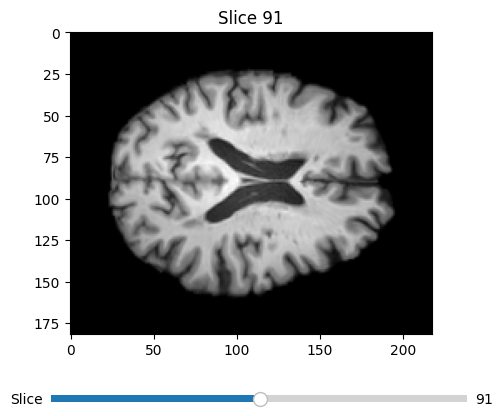

In [5]:
# Define the path using Path for compatibility
nifti_path = Path('/dhc/groups/fglippert/adni_t1_mprage/002_S_0295/MPRAGE/2012-05-10_15_44_50.0/S150055/T1toMNInonlin.nii.gz').resolve()
print("Resolved path:", nifti_path)

if not nifti_path.exists():
    raise FileNotFoundError(f"The file was not found at: {nifti_path}")

# Load the NIfTI image (compressed .nii.gz format)
nifti_img = nib.load(str(nifti_path))  # Convert Path to string if nibabel requires it
image_data = nifti_img.get_fdata()

# Check if the image is 3D
if len(image_data.shape) != 3:
    raise ValueError("The NIfTI image is not 3D. Please provide a 3D image.")

# Initial setup for the figure and axes
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)
slice_index = image_data.shape[2] // 2  # Start with the middle slice

# Display the initial slice
slice_image = ax.imshow(image_data[:, :, slice_index], cmap="gray")
ax.set_title(f"Slice {slice_index}")

# Slider setup
ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor="lightgray")
slice_slider = Slider(ax_slider, "Slice", 0, image_data.shape[2] - 1, valinit=slice_index, valstep=1)

# Update function for the slider
def update(val):
    slice_idx = int(slice_slider.val)
    slice_image.set_data(image_data[:, :, slice_idx])
    ax.set_title(f"Slice {slice_idx}")
    fig.canvas.draw_idle()

# Connect the slider to the update function
slice_slider.on_changed(update)

plt.show()

In [6]:
# metadata
header = nifti_img.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 182 218 182   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.5:9e026117'
aux_file        : b''
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [-1.  0.  0

In [7]:
# Functions
def convert_to_nifti(image_path, nifti_path):
    try:
        img = nib.load(image_path)
        nib.save(img, nifti_path)  # Save as NIfTI format
        # print(f"Successfully converted {image_path} to {nifti_path}")
    except FileNotFoundError:
        print(f"Error: File {image_path} not found. Ensure you're connected to the cluster.")
    except Exception as e:
        print(f"An error occurred while processing {image_path}: {e}")

def preprocess_image(image_path):
    img = nib.load(image_path).get_fdata() 
    # img = np.resize(img, (128, 128, 1))
    img = (img - np.mean(img)) / np.std(img)
    return img

def preprocess_metadata(df):
    # Standardize or one-hot encode features as needed
    df['Age'] = StandardScaler().fit_transform(df[['Age']])
    df = pd.get_dummies(df, columns=['Sex', 'Group'], drop_first=True)
    return df

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def tf_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.img.decode_image(image, channels = 1)
    img = tf.img.resize(image, [128, 128])
    img = img / 255.0 # Normalize [0,1]
    return img

In [8]:
# Load the NIfTI image (compressed .nii.gz format)

# Check if the image is 3D
if len(image_data.shape) != 3:
    raise ValueError("The NIfTI image is not 3D. Please provide a 3D image.")

for i, row in test_df.iterrows():
    image_path = row['path']
    convert_to_nifti(image_path, nifti_path)
    test_df.at[i, 'path'] = nifti_path  # Update path to NIfTI

In [9]:
# Step 4: Splitting the dataset
# Task: Stratify by patients : age, train validation and test 
# Currently runs by picture, is okay for the test of pipeline 
train_data, test_data = train_test_split(test_df, test_size=0.2, random_state=42)
train_data

,Subject,Group,path
11474,002_S_0295,CN,/dhc/groups/fglippert/adni_t1_mprage/002_S_029...
11471,002_S_0295,CN,/dhc/groups/fglippert/adni_t1_mprage/002_S_029...
11473,002_S_0295,CN,/dhc/groups/fglippert/adni_t1_mprage/002_S_029...


In [10]:
# Step 5: Build the (Disentangled) VAE with tensorflow
# NIfTI images are three D!!!

# Parameters
latent_dim = 10
input_shape = (64, 64, 64, 1)  # 3D shape for each volume patch

# Define Encoder
inputs = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='relu', strides=2, padding='same')(inputs)
x = Conv3D(64, (3, 3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv3D(128, (3, 3, 3), activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Define Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(8 * 8 * 8 * 128, activation='relu')(decoder_input)
x = Reshape((8, 8, 8, 128))(x)
x = Conv3DTranspose(128, (3, 3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv3DTranspose(64, (3, 3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv3DTranspose(32, (3, 3, 3), activation='relu', strides=2, padding='same')(x)
outputs = Conv3DTranspose(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

# Compile VAE
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
decoder = Model(decoder_input, outputs, name="decoder")
vae = Model(inputs, decoder(encoder(inputs)[2]), name="vae")

# Define VAE loss
reconstruction_loss = tf.reduce_mean(tf.square(inputs - vae(inputs)))
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

2024-11-14 01:35:14.913761: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


NameError: Exception encountered when calling layer "lambda" (type Lambda).

name 'K' is not defined

Call arguments received by layer "lambda" (type Lambda):
  • inputs=['tf.Tensor(shape=(None, 10), dtype=float32)', 'tf.Tensor(shape=(None, 10), dtype=float32)']
  • mask=None
  • training=None

In [ ]:
#vae.fit(train_data, epochs=50, batch_size=64)